In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl



In [4]:
movies_df = pd.read_csv("ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Question 1

In [6]:
total_users = ratings_df.userId.unique()
len(total_users)
all_pos_ratings = len(movies_df) * len(total_users)
sparsity = len(ratings_df) / all_pos_ratings
print("Total number of possible ratings:", all_pos_ratings)
print("Total number of available ratings:", len(ratings_df))
print("Sparsity", sparsity)

Total number of possible ratings: 5942620
Total number of available ratings: 100836
Sparsity 0.016968273253211548


## Question 2

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


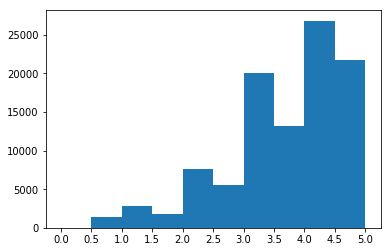

In [7]:
r_bins = [x / 10.0 for x in range(0, 51, 5)]
print(r_bins)
plt.hist(ratings_df.rating, bins=r_bins)
plt.xticks(r_bins)
plt.show()

The distribution is left skewed. People are more willing to rat the movies they like than rating the movies they displike.

## Question 3

In [8]:
movie_ratings = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "movieId"]
    if id in movie_ratings:
        movie_ratings[id] = movie_ratings[id] + 1
    else:
        movie_ratings[id] = 1

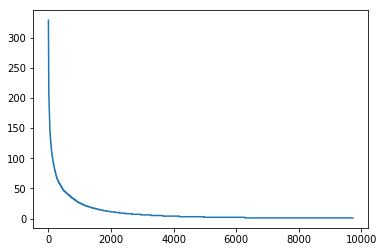

In [9]:
movie_lists = sorted(movie_ratings.items(), key=lambda x:-x[1]) #sorted by key
x_id,y_cnt = zip(*movie_lists)
xs = range(len(x_id))
plt.plot(xs, y_cnt)
plt.show()

## Question 4

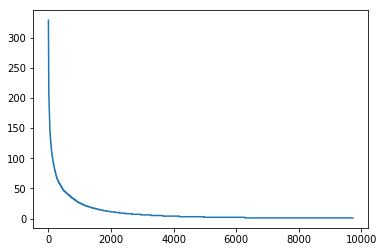

In [10]:
user_cnt = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "userId"]
    if id in user_cnt:
        user_cnt[id] = user_cnt[id] + 1
    else:
        user_cnt[id] = 1
user_list = sorted(user_cnt.items(), key=lambda x:-x[1])
user_list
u_id,y_cnt = zip(*movie_lists)
xs = range(len(u_id))
plt.plot(xs, y_cnt)
plt.show()

## Question 5

The distribution has a really long tail, and this means that only a small portion of the movies have lots of ratings most of the movies have a small number of ratings. This means that the matrix is very sparse. The sparse matrix limits the coverage of neighborhood-based methods, and this creates challenges for robust similarity computation.

## Question 6

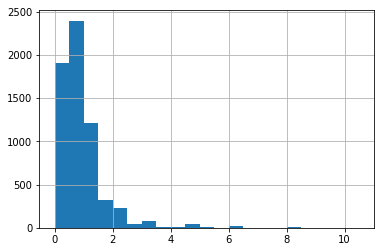

In [11]:
movie_var = ratings_df.groupby(['movieId'])['rating'].var()
movie_var.head()
max_var = movie_var.max()
min_var = movie_var.min()
v_bins = [i / 10.0 for i in range(0, 106, 5)]
movie_var.hist(bins=v_bins)
# plt.xticks(v_bins)
plt.show()

The distribution means that the ratings on the movies are very consistent. Most of the movie have very low variance, and only small amount of movie have high variance in terms of reviews.

## Question 7

$\mu_u = \frac{\Sigma_{k \in I_u}}{|I_u|}$

## Question 8

This means the set of items have been rated both by user u and user v. When the two sets are disjoint these two sets have not purchased any common item.

## Question 9

In [11]:
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans

## Question 10-11

In [ ]:
def knn_filter(data_set, krange):
    mae_results = []
    rmse_results = []

    for i in krange:
        result = cross_validate(KNNWithMeans(k=i, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False),
                                data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

#         print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)
    print("Minimum MAE = "mae_resultsin(mae_results))
    print("Minimum RMSE = ", min(rmse_results))
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()



2
MAE =  0.7858430805750529
RMSE =  1.0189213755664983
4
MAE =  0.7264441520411584
RMSE =  0.9451077879377516
6
MAE =  0.7046581112652233
RMSE =  0.9202266693666742
8
MAE =  0.6940723488247764
RMSE =  0.9077723474564247
10
MAE =  0.6883164386155809
RMSE =  0.9016826379004158
12
MAE =  0.6855756880640981
RMSE =  0.8979649390130356
14
MAE =  0.6816161961862379
RMSE =  0.8936195591776844
16
MAE =  0.6817317088609584
RMSE =  0.8940476774555369
18
MAE =  0.6803022073563704
RMSE =  0.892381274995846
20
MAE =  0.6787957468323398
RMSE =  0.8913894218989629
22
MAE =  0.6792800784149398
RMSE =  0.8916314057855862
24
MAE =  0.679103611536727
RMSE =  0.8913456970414915
26
MAE =  0.6781200798546806
RMSE =  0.890319913687787
28
MAE =  0.6782780410764561
RMSE =  0.8909582738170247
30
MAE =  0.6782354208296921
RMSE =  0.8897438153524238
32
MAE =  0.6773983397355057
RMSE =  0.8902082073844859
34
MAE =  0.6774445222637283
RMSE =  0.8903735571247537
36
MAE =  0.6773018048446247
RMSE =  0.8898838276194608

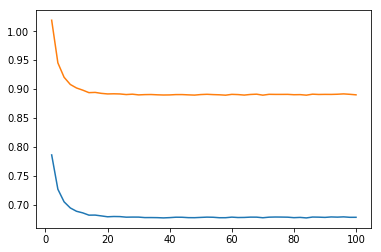

In [44]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 102, 2)
knn_filter(data_set, krange)

In [7]:
from surprise.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Question 12-14

In [54]:
# trim test dataset
popular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) > 2)
unpopular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) <= 2)
at_least_5_ratings_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) >= 5)
high_var_df = at_least_5_ratings_df.groupby(['movieId']).filter(lambda x: (x['rating']).var() >= 2)
print(high_var_df.shape)
print (ratings_df.shape)
print (popular_movie_df.shape)
print (unpopular_movie_df.shape)

(586, 4)
(100836, 4)
(94794, 4)
(6042, 4)


In [55]:
print("Popular Movies")
knn_filter(Dataset.load_from_df(popular_movie_df, reader), krange)
print("Unpopular Movies")
knn_filter(Dataset.load_from_df(unpopular_movie_df, reader), krange)
print("High-variance Movies")
knn_filter(Dataset.load_from_df(high_var_df, reader), krange)

Popular Movies


NameError: name 'knn_filter' is not defined

## Question 15

In [154]:
def binary_predict(alg, data_set, thresholds):
    training_set, test_set = train_test_split(data_set, test_size = 0.1)
    alg.fit(training_set)
    predictions = alg.test(test_set)
    for t in thresholds:
        binary_preditions = [0 if pred.est < t else 1 for pred in predictions]
        binary_truth = [pred.r_ui for pred in predictions]
        fpr, tpr, _ = roc_curve(binary_preditions, binary_truth)
        draw_roc(fpr, tpr)

def draw_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('AUC = ', roc_auc)
   

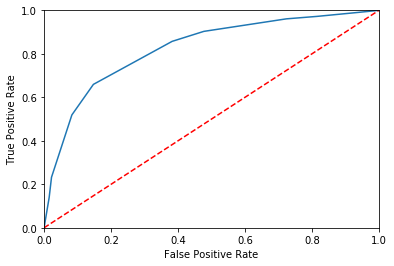

AUC =  0.8253103774714715


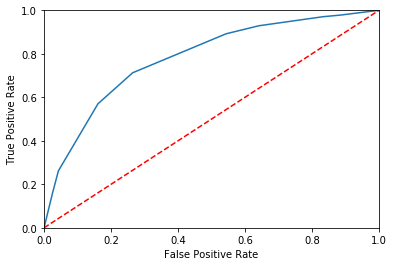

AUC =  0.7808374049361666


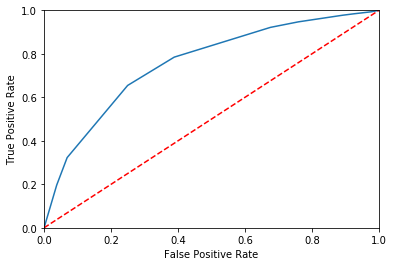

AUC =  0.75763375242396


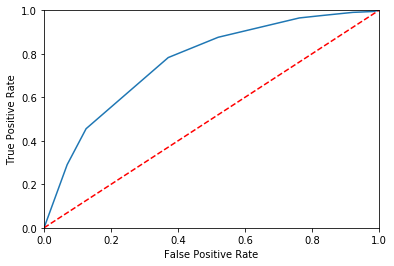

AUC =  0.7635639697319943


In [155]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
thresholds = [2.5, 3.0, 3.5, 4.0]
binary_predict(KNNWithMeans(k=16, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False), data_set, thresholds)

## Question 17 - 22 NNMF

In [10]:
from surprise.prediction_algorithms.matrix_factorization import NMF

In [ ]:
def nnmf_filter(data_set, krange):
    mae_results = []
    min_mae = 99999999999
    min_mae_i = -1

    rmse_results = []
    min_rmse = 9999999999
    min_rmse_i = -1

    for i in krange:
        result = cross_validate(NMF(n_factors=i, biased=False), data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        if avg_mae < min_mae:
            min_mae = avg_mae
            min_mae_i = i

        if avg_rmse < min_rmse:
            min_rmse = avg_rmse
            min_rmse_i = i
#         print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)

    print("Best k for MAE is: ", min_mae_i, "MAE = ", min_mae)
    print("Best k for RMSE is: ", min_rmse_i, "RMSE = ", min_rmse)
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()

2
MAE =  0.9616203309936271
RMSE =  1.1437609712659786
4
MAE =  0.8491287236938216
RMSE =  1.038805797617638
6
MAE =  0.7869687909657925
RMSE =  0.9832903837747524
8
MAE =  0.7455003613451122
RMSE =  0.9468202897687089
10
MAE =  0.7251955586568657
RMSE =  0.9302878531917514
12
MAE =  0.7102268800390528
RMSE =  0.9198031768731607
14
MAE =  0.7033949795794989
RMSE =  0.9158753687801763
16
MAE =  0.696801034799028
RMSE =  0.9122713786634818
18
MAE =  0.6951944730006574
RMSE =  0.9140371441160788
20
MAE =  0.6937173926208843
RMSE =  0.9142182671347798
22
MAE =  0.6949271298816658
RMSE =  0.9175064056353012
24
MAE =  0.6955185606574582
RMSE =  0.9204996598316558
26
MAE =  0.6961707814367288
RMSE =  0.9213075886614492
28
MAE =  0.699194936358494
RMSE =  0.9270985018990455
30
MAE =  0.7006730694781724
RMSE =  0.9287511286552285
32
MAE =  0.7031417754772237
RMSE =  0.9331357377637921
34
MAE =  0.706344161412339
RMSE =  0.9373857799791377
36
MAE =  0.7106119920972722
RMSE =  0.942826460739456
3

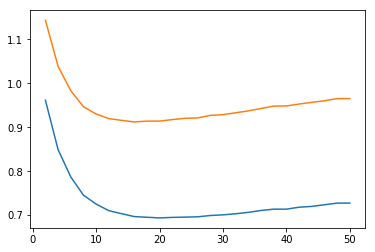

In [32]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 52, 2)
nnmf_filter(data_set, krange)

In [59]:
print("Popular Movies")
nnmf_filter(Dataset.load_from_df(popular_movie_df, reader), krange)
print("Unpopular Movies")
nnmf_filter(Dataset.load_from_df(unpopular_movie_df, reader), krange)
print("High-variance Movies")
nnmf_filter(Dataset.load_from_df(high_var_df, reader), krange)

Popular Movies


NameError: name 'nnmf_filter' is not defined

## Question 22

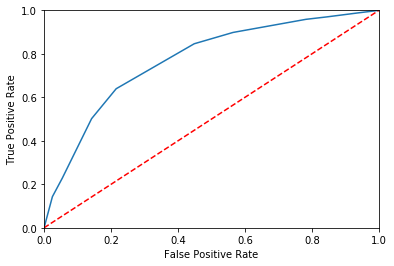

AUC =  0.7709763281586738


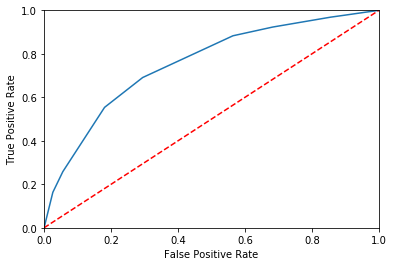

AUC =  0.7549040758302543


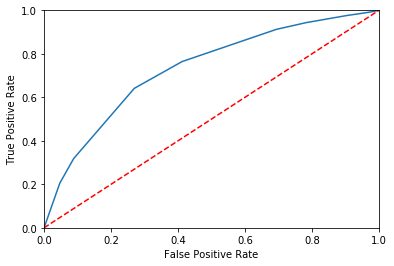

AUC =  0.732730598067276


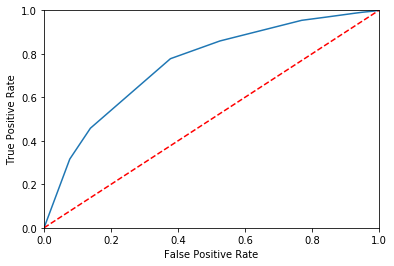

AUC =  0.7514716244753353


In [62]:
binary_predict(NMF(n_factors=16, biased=False), data_set, thresholds)

## Question 23

In [122]:
movie_to_genre = pd.read_csv('ml-latest-small/movies.csv')
movie_to_rating = pd.read_csv('ml-latest-small/ratings.csv')
movie_names = movie_to_rating.movieId.unique()
m_to_g = movie_to_genre[movie_to_genre["movieId"].isin(movie_names)]

nnmf_clf = NMF(n_factors=20, biased=False)
nnmf_clf.fit(data_set.build_full_trainset())
V = nnmf_clf.qi
print(len(list(V[:,0])))
for i in range(20):
    movies = list(V[:,i])
    moviesTuple = []
    for idx in range(len(movies)):
        moviesTuple.append((idx, movies[idx]))
    moviesTuple.sort(key = lambda x:x[1], reverse=True)
    print ("i = ", i)
    for tup in moviesTuple[0:10]:
        print (m_to_g['genres'][tup[0]])

9724
i =  0
Adventure|Drama|Western
Action|Drama|War
Comedy
Comedy|Drama|Romance
Drama|Fantasy|Romance
Crime|Drama
Drama|Horror
Action|Animation
Comedy|Drama|Romance
Action|Crime|Drama
i =  1
Comedy|Romance
Action|Adventure|Thriller
Comedy|Drama|Thriller
Drama|Musical|Romance
Action|Crime|Horror
Drama
Adventure|Comedy|Romance
Comedy|Drama
Drama
Drama
i =  2
Action|Drama|Thriller
Drama
Drama|Horror|Mystery|Thriller
Comedy
Drama|Romance|War
Adventure|Animation|Comedy
Action|Crime|Drama|Thriller
War
Drama
Crime|Drama|Mystery|Thriller
i =  3
Comedy|Drama|Romance
Adventure|Children|Comedy
Comedy|Horror|Romance|Thriller
Comedy|Crime
Action|Crime|Drama|Thriller
Comedy
Action|Adventure|Drama|War
Crime|Horror|Thriller
Drama|Romance
Drama
i =  4
Drama|War
Children|Comedy
Action|Sci-Fi|Thriller
Comedy|Horror
Action|Drama|War
Comedy
Comedy|Romance
Comedy|Drama
Action|Crime|Fantasy|Thriller
Comedy
i =  5
Drama|Mystery|Thriller
Horror|Thriller
Horror|Sci-Fi
Drama
Action|Drama|War
Comedy
Action|Drama

## Question 24-29 MF With Bias

In [9]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [ ]:
def svd_filter(data_set, krange):
    mae_results = []
    min_mae = 99999999999
    min_mae_i = -1

    rmse_results = []
    min_rmse = 9999999999
    min_rmse_i = -1

    for i in krange:
        result = cross_validate(SVD(n_factors=i, biased=False), data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        if avg_mae < min_mae:
            min_mae = avg_mae
            min_mae_i = i

        if avg_rmse < min_rmse:
            min_rmse = avg_rmse
            min_rmse_i = i
        print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)

    print("Best k for MAE is: ", min_mae_i, "MAE = ", min_mae)
    print("Best k for RMSE is: ", min_rmse_i, "RMSE = ", min_rmse)
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()

In [ ]:
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
svd_filter(data_set, krange)

In [ ]:
print("Popular Movies")
svd_filter(Dataset.load_from_df(popular_movie_df, reader), krange)
print("Unpopular Movies")
svd_filter(Dataset.load_from_df(unpopular_movie_df, reader), krange)
print("High-variance Movies")
svd_filter(Dataset.load_from_df(high_var_df, reader), krange)

## Question 29

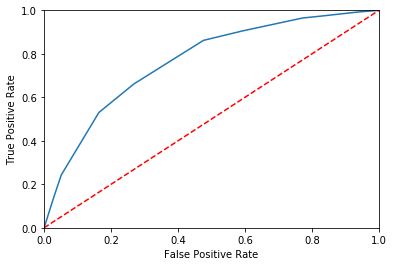

AUC =  0.7652853048594729


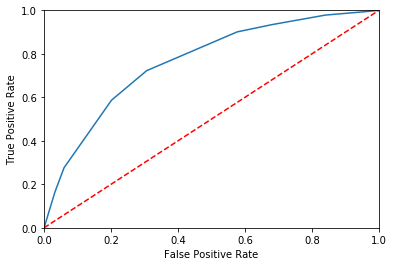

AUC =  0.7640147844873751


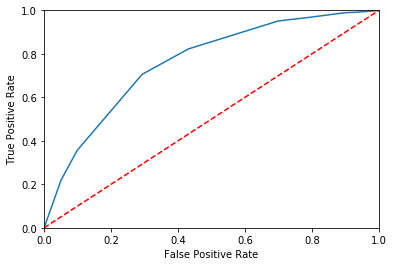

AUC =  0.7599305625622722


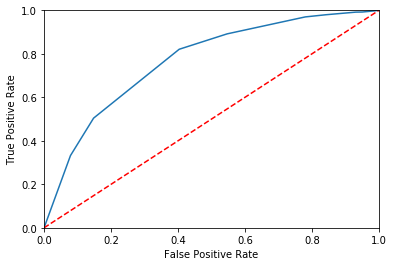

AUC =  0.7679977387346729


In [67]:
binary_predict(SVD(n_factors=18, biased=False), data_set, thresholds)

In [17]:
def user_ranking(clf_str, training_set_df, test_set_df):
    if clf_str == "MF":
        clf = SVD(n_factors=16, biased=False)
    elif clf_str == "NNMF":
        clf = NMF(n_factors=16, biased=False)
    elif clf_str == "KNN":
        clf = KNNWithMeans(k=16, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False)
    reader = Reader(rating_scale=(0.5, 5))
    training_set = Dataset.load_from_df(training_set_df[['userId', 'movieId', 'rating']], reader).build_full_trainset()
    test_set = Dataset.load_from_df(test_set_df[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
    clf.fit(training_set)
    predictions = clf.test(test_set)
    
    pred_per_user = {}
    for pred in predictions:
        uid = pred.uid
        if uid not in pred_per_user:
            pred_per_user[uid] = [pred]
        else:
            pred_per_user[uid].append(pred)
    result = {}
#     result_test={}
    for uid in pred_per_user:
        pred_per_user[uid].sort(key = lambda x:x.est, reverse=True)
#         result_test[uid] = [x.est for x in pred_per_user[uid]]
        result[uid] = [x.iid for x in pred_per_user[uid]]
    return result

# Navie Collaborative Filtering

In [105]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Question 30

In [106]:
class NaiveCollabFilter:
    
    def __init__(self, ratings_df):
        self.user_means = ratings_df.groupby(['userId'])['rating'].mean()
        self.total_mean = ratings_df["rating"].mean()
    
    def predictCollab(self, user_id):
        if user_id in self.user_means.index:
            return self.user_means[user_id]
        else:
            return self.total_mean
    
clf = NaiveCollabFilter(ratings_df)

In [107]:
def K_FoldCollab(given_df):
    kf = KFold(n_splits = 10, shuffle=True)
    kf.get_n_splits(given_df)
    rmse = list()
    for train_idx, test_idx in kf.split(given_df):
        print ("processing")
        clf = NaiveCollabFilter(given_df.iloc[train_idx])
        y_pred = list()
        y_true = list()
        for t_idx in test_idx:
            user_id = given_df.iloc[t_idx].userId
            y_pred.append(clf.predictCollab(user_id))
            y_true.append(given_df.iloc[t_idx].rating)
        rmse.append(mean_squared_error(y_true, y_pred)**(1/2))
    print (rmse)
    print("Average RMSE: ", np.average(rmse))
K_FoldCollab(ratings_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9407665177218398, 0.941453901301321, 0.9361629339217006, 0.9380051635507416, 0.934161513445694, 0.941506329673521, 0.9396801161320192, 0.9423750086426163, 0.9416632623277399, 0.9541325272295417]
Average RMSE:  0.9409907273946734


## Question 31

In [108]:
popular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) > 2)
K_FoldCollab(popular_movie_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9459880176747286, 0.9384251113744843, 0.9311299022772981, 0.9398118083394815, 0.9305849704559016, 0.936149692052525, 0.9328483797229609, 0.9408594320925973, 0.9406445720512261, 0.9382180191395508]
Average RMSE:  0.9374659905180754


## Question 32

In [109]:
unpopular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) <= 2)
K_FoldCollab(unpopular_movie_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9213225951110378, 0.8753181570507349, 0.8790291614441124, 0.9313582614887248, 0.9131977366732966, 0.8844487431326967, 0.8773837597173177, 0.8931838856866903, 0.8814259071142284, 0.9112238040885402]
Average RMSE:  0.8967892011507379


## Question 33

In [114]:
at_least_5_ratings_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) >= 5)
high_var_df = at_least_5_ratings_df.groupby(['movieId']).filter(lambda x: (x['rating']).var() >= 2)
K_FoldCollab(high_var_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[1.3980763082022107, 1.5824506116748753, 1.4210315773653637, 1.60794730576822, 1.2783196288904874, 1.1783632597365736, 1.2759714224336107, 1.489567185211815, 1.385193984778796, 1.352941410914258]
Average RMSE:  1.3969862694976212


## Question 35

Precision: The percentage of recommended items that are liked by the users. This measures how many recommned items are liked by the users.
Recall: The percentage of the liked items that are recommended to the users. This basically measures how many liked items have been recommended.

## Question 36

In [96]:
def getPreciAndRecall(pred_res, g_truth, t):
    true_pos = 0
    for i in range(t):
        if pred_res[i] in g_truth:
            true_pos += 1
    recall = float(true_pos)/ len(g_truth)
    return (float(true_pos) / t, recall)

def averagePreciAndRecall(all_user_res, all_g_truth, t):
    total_preci = 0
    total_recall = 0
    user_cnt = 0
    user_num = len(all_user_res)
    for user in all_user_res:
        if (user not in all_g_truth) or (len(all_user_res[user])) < t:
            user_num -= 1
            continue
        preci, recall = getPreciAndRecall(all_user_res[user], all_g_truth[user], t)
        total_preci += preci
        total_recall += recall
    return (float(total_preci)/user_num, float(total_recall)/user_num)

def getAllTruth(all_user_res, ratings_df):
    all_g_truth = dict()
    for user in all_user_res:
        res_df = ratings_df[(ratings_df["userId"]==user) & (ratings_df["rating"] >= 3.0)]
        if len(res_df) == 0: #drop 0 ground truth
            continue
        all_g_truth[user] = res_df["movieId"].unique().tolist()
#         print ("user: ", user)
#         print (all_g_truth[user])
    return all_g_truth

In [101]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
def K_FoldAverage(given_df, clf_str):
    kf = KFold(n_splits = 10, shuffle=True)
    kf.get_n_splits(given_df)
    rmse = list()
    preci_to_all_ts = dict()
    recall_to_all_ts = dict()
    for train_idx, test_idx in kf.split(given_df):
        print ("processing")
        train_df = given_df.iloc[train_idx]
        test_df = given_df.iloc[test_idx]
        print (len(test_df), len(train_df))
        all_user_res = user_ranking(clf_str, train_df, test_df)
        all_g_truth = getAllTruth(all_user_res, test_df)
        for t in range(1, 26):
            if t not in preci_to_all_ts:
                preci_to_all_ts[t] = list()
                recall_to_all_ts[t] = list()
            preci, recall = averagePreciAndRecall(all_user_res, all_g_truth, t)
            preci_to_all_ts[t].append(preci)
            recall_to_all_ts[t].append(recall)
#         print(sum([len(all_g_truth[x]) for x in all_g_truth]))
    preci_avg = dict()
    recall_avg = dict()
    for t in range(1, 26):
#         print(preci_to_all_ts[t])
        preci_avg[t] = np.mean(preci_to_all_ts[t])
        recall_avg[t] = np.mean(recall_to_all_ts[t])
    return (preci_avg, recall_avg)


In [102]:
preci_to_all_ts, recall_to_all_ts = K_FoldAverage(ratings_df, "MF")

processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10083 90753
processing
10083 90753
processing
10083 90753
processing
10083 90753


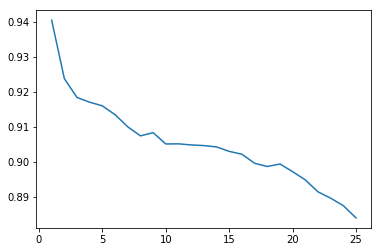

In [103]:
t_s = range(1, 26)
plt.plot(t_s, [preci_to_all_ts[t] for t in t_s])
plt.show()

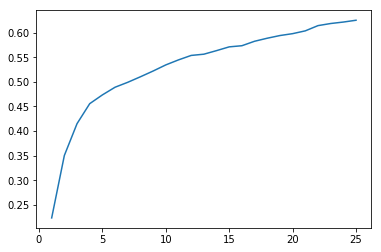

In [104]:
t_s = range(1, 26)
plt.plot(t_s, [recall_to_all_ts[t] for t in t_s])
plt.show()